# Path Planning

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from heapq import heappush, heappop

In [ ]:
def heuristic(p1, p2):
    # Implement the Manhattan distance heuristic
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

In [ ]:
def a_star_search(points,path):
    """
    A* 

    input: 
        points: N x 2 array (N = (# of corners) + 2), where:
            - The first row represents the start position.
            - The second row represents the goal position.
            - The remaining rows contain the coordinates of the extended corners.
        path: N X N, is equal to 1 if two corners are directly connected 
              by a line that does not cross any obstacle, and 0 otherwise.

    output: 
        shortest_path: M X 2 (M = # of corners in the shortest path), A list 
            of corner indices representing the shortest path from start to goal.
    """

    
    # Initialize the open set as a priority queue and add the start node
    open_set = []
    start_index = 0
    start = points[0,:]
    goal_index = 1
    goal = points[1,:]
    corners = points[2:,:]

    heappush(open_set, (heuristic(start, goal), 0, start_index))  # (f_cost, g_cost, position)

    # Initialize the came_from dictionary
    came_from = {}
    # Initialize g_costs dictionary with default value of infinity and set g_costs[start] = 0
    g_costs = {start: 0}
    # Initialize the explored set
    explored = set()
    operation_count = 0

    while open_set:
        # Pop the node with the lowest f_cost from the open set
        current_f_cost, current_g_cost, current_index = heappop(open_set)
        # Add the current node to the explored set
        explored.add(current_index)

        # For directly reconstruct path
        if current_index == goal_index:
            break

        # Get the neighbors of the current node (up, down, left, right)
        neighbors_index = 
        neighbors = [
            (current_pos[0] - 1, current_pos[1]),  # Up
            (current_pos[0] + 1, current_pos[1]),  # Down
            (current_pos[0], current_pos[1] - 1),  # Left
            (current_pos[0], current_pos[1] + 1)   # Right
        ]

        for neighbor in neighbors:
            # Check if neighbor is within bounds and not an obstacle
            if (0 <= neighbor[0] < map_grid.shape[0]) and (0 <= neighbor[1] < map_grid.shape[1]):
                if map_grid[neighbor[0], neighbor[1]] != -1 and neighbor not in explored:
                    # Calculate tentative_g_cost
                    tentative_g_cost = current_g_cost + 1 + map_grid[neighbor[0], neighbor[1]]

                    # If this path to neighbor is better than any previous one
                    if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                        # Update came_from, g_costs, and f_cost
                        came_from[neighbor] = current_pos
                        g_costs[neighbor] = tentative_g_cost
                        f_cost = tentative_g_cost + heuristic(neighbor, goal)

                        # Add neighbor to open set
                        heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                        operation_count += 1
    

In [8]:
def a_star_search(map_grid, start, goal):
    # Initialize the open set as a priority queue and add the start node
    open_set = []
    heappush(open_set, (heuristic(start, goal), 0, start))  # (f_cost, g_cost, position)

    # Initialize the came_from dictionary
    came_from = {}
    # Initialize g_costs dictionary with default value of infinity and set g_costs[start] = 0
    g_costs = {start: 0}
    # Initialize the explored set
    explored = set()
    operation_count = 0

    while open_set:
        # Pop the node with the lowest f_cost from the open set
        current_f_cost, current_g_cost, current_pos = heappop(open_set)

        # Add the current node to the explored set
        explored.add(current_pos)

        # For directly reconstruct path
        if current_pos == goal:
            break

        # Get the neighbors of the current node (up, down, left, right)
        neighbors = [
            (current_pos[0] - 1, current_pos[1]),  # Up
            (current_pos[0] + 1, current_pos[1]),  # Down
            (current_pos[0], current_pos[1] - 1),  # Left
            (current_pos[0], current_pos[1] + 1)   # Right
        ]

        for neighbor in neighbors:
            # Check if neighbor is within bounds and not an obstacle
            if (0 <= neighbor[0] < map_grid.shape[0]) and (0 <= neighbor[1] < map_grid.shape[1]):
                if map_grid[neighbor[0], neighbor[1]] != -1 and neighbor not in explored:
                    # Calculate tentative_g_cost
                    tentative_g_cost = current_g_cost + 1 + map_grid[neighbor[0], neighbor[1]]

                    # If this path to neighbor is better than any previous one
                    if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                        # Update came_from, g_costs, and f_cost
                        came_from[neighbor] = current_pos
                        g_costs[neighbor] = tentative_g_cost
                        f_cost = tentative_g_cost + heuristic(neighbor, goal)

                        # Add neighbor to open set
                        heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                        operation_count += 1

    # Reconstruct path
    if current_pos == goal:
        path = []
        while current_pos in came_from:
            path.append(current_pos)
            current_pos = came_from[current_pos]
        path.append(start)
        return path[::-1], explored,operation_count
    else:
        # If we reach here, no path was found
        return None, explored,operation_count

Path found:
Number of operations: 47


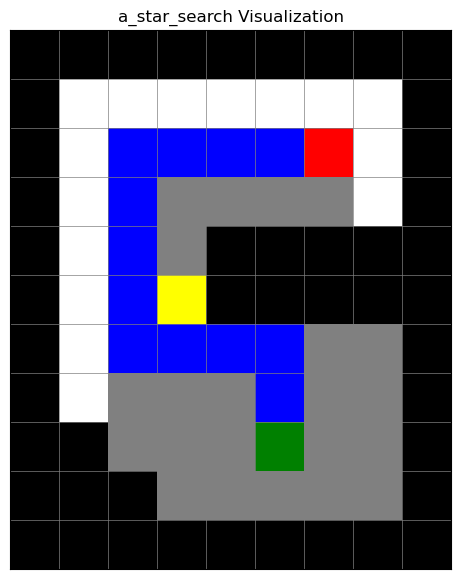

In [9]:
def display_map(map_grid, path, start, goal, explored):
    cmap = ListedColormap(['white', 'black', 'blue', 'green', 'red', 'grey', 'yellow'])
    map_display = np.zeros_like(map_grid, dtype=object)

    # Assign colors based on the map grid values
    map_display[map_grid == -1] = 'black'  # Obstacles
    map_display[map_grid == 0] = 'white'   # Free space

    for position in explored:
        if map_display[tuple(position)] == 'white':
            map_display[tuple(position)] = 'grey'  # Explored cells

    # Visualize the path
    for position in path:
        if map_display[position[0], position[1]] in ['white', 'grey']:
            map_display[position[0], position[1]] = 'blue'  # Path

    map_display[5, 3] = 'yellow' # Weighted cell
    map_display[start[0], start[1]] = 'green'  # Start
    map_display[goal[0], goal[1]] = 'red'      # Goal

    # Convert color names to numbers for plotting
    color_mapping = {'white': 0, 'black': 1, 'blue': 2, 'green': 3, 'red': 4, 'grey': 5, 'yellow': 6}
    map_numeric_display = np.vectorize(color_mapping.get)(map_display)
    fig, ax = plt.subplots(figsize=(6, 7))
    ax.imshow(map_numeric_display, cmap=cmap)
    ax.set_xticks(np.arange(-0.5, map_grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, map_grid.shape[0], 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.set_title('a_star_search Visualization')
    plt.show()

Map = np.zeros((11, 9))

Map[5, 3] = 2; # Weighted cell

Map[0, :] = -1; Map[10, :] = -1; Map[:, 0] = -1; Map[:, 8] = -1
Map[8, 1] = -1; Map[9, 1] = -1; Map[9, 2] = -1; Map[4:6, 4:8] = -1
SearchStart = (8, 5) 
SearchGoal  = (2, 6)

path, explored,operation_count = a_star_search(Map, SearchStart, SearchGoal)

# Display the result
if path:
    print("Path found:")
    print(f"Number of operations: {operation_count}")
    display_map(Map, path, SearchStart, SearchGoal, explored)
else:
    print("No path found.")